In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

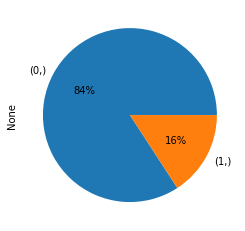

In [3]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

### Test ensamble CB and LGBM (Promedio Simple)

In [4]:
train = pd.read_pickle('../data/train_features680_score_0.85558.pkl') 
test = pd.read_pickle('../data/test_features680_score_0.85558.pkl')
train.shape, test.shape

((358487, 680), (396666, 680))

In [5]:
### fi_lightgbm del cat features
fi = pd.read_pickle('fi_lightgbm.pkl')
fi.sort_values(ascending=False).head(500).sum()

0.9385765410554683

In [8]:
from lightgbm import LGBMClassifier
fi = pd.read_pickle('fi_lightgbm.pkl')
features_importances_250_lightgbm = list(fi.sort_values(ascending=False).head(680).index)
learner_lightgbm = LGBMClassifier(n_estimators=1000, max_depth=6, boosting_type='gbdt', min_child_samples=1000)
learner_lightgbm.fit(train[features_importances_250_lightgbm], y_train.target, eval_metric="auc", verbose=True)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=6,
               min_child_samples=1000, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [9]:
from catboost import CatBoostClassifier
fi = pd.read_pickle('fi_catboost.pkl')
features_importances_250_catboost = list(fi.sort_values(ascending=False).head(680).index)
learner_catboost = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth = 6)
learner_catboost.fit(train[features_importances_250_catboost], y_train,  early_stopping_rounds=10, verbose=False)

In [10]:
test_probs_catboost = pd.Series(learner_catboost.predict_proba(test[features_importances_250_catboost])[:, -1], index=test.index, name="target")
test_probs_lightgbm = pd.Series(learner_lightgbm.predict_proba(test[features_importances_250_lightgbm])[:, -1], index=test.index, name="target")
test_probs_mean = test_probs_catboost*0.4 + test_probs_lightgbm*0.6
test_probs_mean.name = 'target'
test_probs_mean.shape

(396666,)

In [11]:
# test_probs_mean.to_csv('../results/ensamble_simple.csv')  ### score de ****** en la tabla publica

In [12]:
test_stacking = pd.read_csv("../results/stacking_4models_LGBM2_CB_GBC_0.85517.csv", index_col = 'key_value')
test_stacking = pd.Series(test_stacking['target'], index=test_stacking.index)
test_stacking

key_value
0         0.045024
1         0.067199
2         0.052986
3         0.587453
4         0.127642
            ...   
396661    0.065888
396662    0.149657
396663    0.186598
396664    0.057022
396665    0.056621
Name: target, Length: 396666, dtype: float64

In [13]:
test_probs_mean_total = test_probs_mean*0.4 + test_stacking*0.6
test_probs_mean_total

key_value
0         0.028176
1         0.061399
2         0.042969
3         0.550429
4         0.148763
            ...   
396661    0.064849
396662    0.172741
396663    0.192980
396664    0.051571
396665    0.049153
Name: target, Length: 396666, dtype: float64

In [14]:
test_probs_mean_total.to_csv("../results/emsamble_simple_and_stacking_v4.csv") ### score de 0.85615  en la tabla publica

In [ ]:
########### Probando

In [24]:
test_probs_mean_total_v2 = pd.read_csv("../results/emsamble_simple_and_stacking_v3.csv") ### score de 0.85605  en la tabla publica
test_probs_mean_total_v3 = pd.read_csv("../results/emsamble_simple_and_stacking_v4.csv") ### score de 0.85615  en la tabla publica

In [25]:
test_probs_mean_total_v2 = pd.Series(test_probs_mean_total_v2['target'], index=test_stacking.index)
test_probs_mean_total_v3 = pd.Series(test_probs_mean_total_v3['target'], index=test_stacking.index)
test_probs_mean_total_full = test_probs_mean_total_v2*0.5 + test_probs_mean_total_v3*0.5
test_probs_mean_total_full

key_value
0         0.028038
1         0.063374
2         0.044073
3         0.566206
4         0.137851
            ...   
396661    0.065504
396662    0.172110
396663    0.190344
396664    0.050897
396665    0.048405
Name: target, Length: 396666, dtype: float64

In [26]:
test_probs_mean_total_full.to_csv("../results/emsamble_simple_and_stacking_v4_v3_avg.csv") ### score de **** en la tabla publica